In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data = pd.read_csv('rentfaster.csv')

In [4]:
data

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25767,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,1450.0,3 Beds,1,810,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25768,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1125.0,1 Bed,1,520,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True
25769,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rentfaster_id      25771 non-null  int64  
 1   city               25771 non-null  object 
 2   province           25771 non-null  object 
 3   address            25646 non-null  object 
 4   latitude           25771 non-null  float64
 5   longitude          25771 non-null  float64
 6   lease_term         25725 non-null  object 
 7   type               25771 non-null  object 
 8   price              25771 non-null  float64
 9   beds               25639 non-null  object 
 10  baths              25637 non-null  object 
 11  sq_feet            21659 non-null  object 
 12  link               25771 non-null  object 
 13  furnishing         25771 non-null  object 
 14  availability_date  25759 non-null  object 
 15  smoking            23069 non-null  object 
 16  cats               255

In [6]:
data.describe()

,rentfaster_id,latitude,longitude,price
count,25771.000000,25771.000000,25771.000000,25771.000000
mean,471913.795274,48.903370,-100.332196,2151.624142
std,120330.335865,3.603257,17.917001,972.820941
min,820.000000,40.741802,-128.661880,0.000000
25%,415749.000000,45.418785,-114.074660,1600.000000
50%,522379.000000,50.913739,-113.513905,2045.000000
75%,563397.500000,51.093585,-79.401311,2550.000000
max,572635.000000,62.459246,-52.695472,29990.000000


In [7]:
data.dropna(inplace=True) # modifying the original DataFrame to drop rows with null values

In [8]:
data.describe()

,rentfaster_id,latitude,longitude,price
count,19337.000000,19337.000000,19337.000000,19337.000000
mean,460840.405492,49.161789,-101.672469,2166.144573
std,125130.935253,3.531318,17.473785,893.703637
min,820.000000,42.040814,-128.661880,0.000000
25%,394521.000000,45.468491,-114.078523,1650.000000
50%,508373.000000,50.972034,-113.532879,2067.860000
75%,559539.000000,51.105808,-79.577513,2550.000000
max,572635.000000,62.459246,-52.695472,26500.000000


In [9]:
X = data.drop(['price'], axis=1)
y = data['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [11]:
train_data = X_train.join(y_train)

array([[<Axes: title={'center': 'rentfaster_id'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

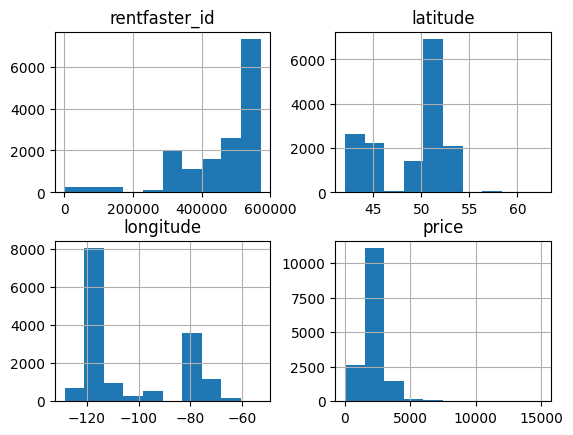

In [12]:
train_data.hist()

<Axes: >

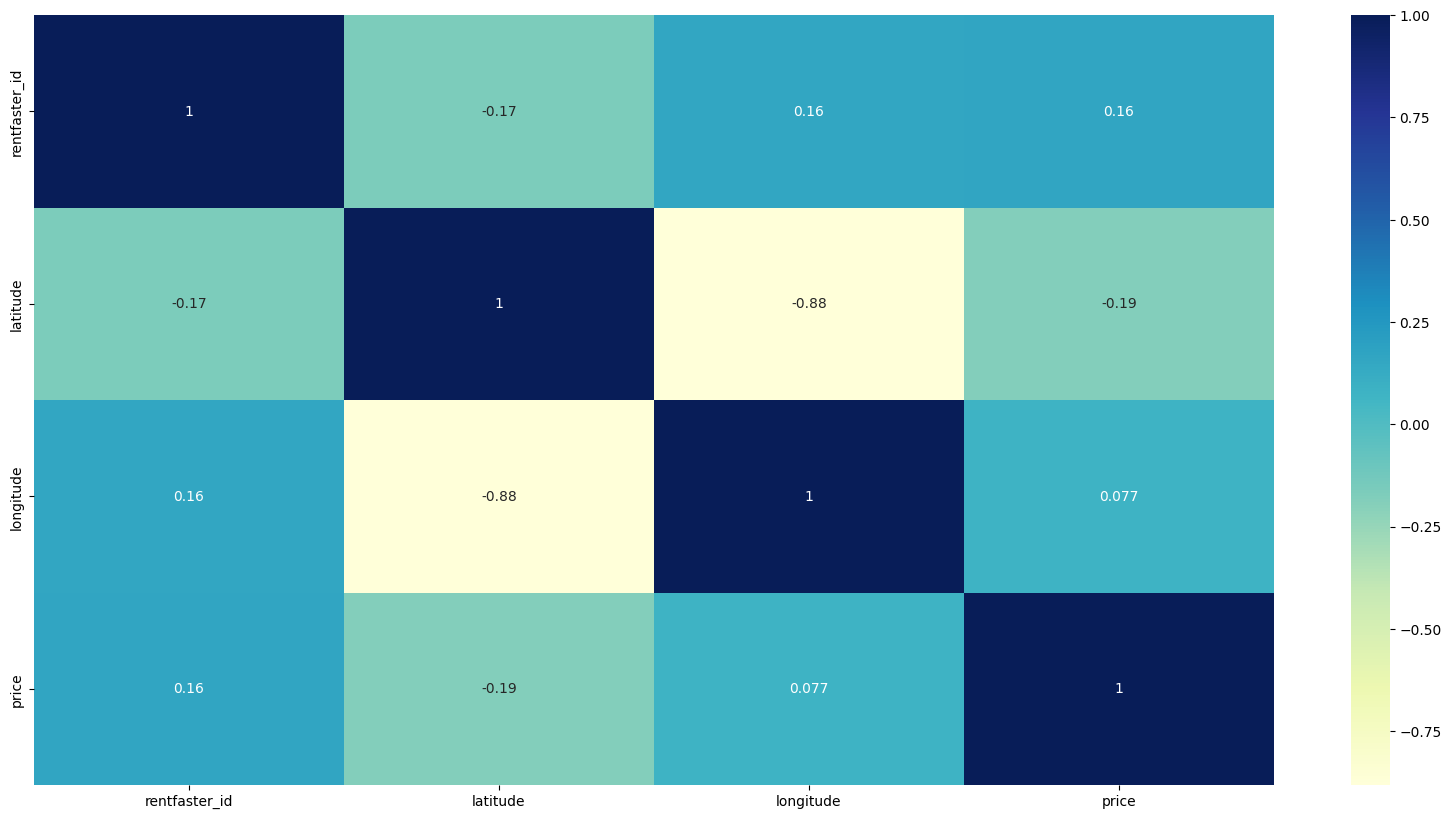

In [13]:
numeric_data = train_data.select_dtypes(include=[np.number])
plt.figure(figsize=(20,10))
sns.heatmap(numeric_data.corr(),annot=True, cmap="YlGnBu")

In [14]:
train_data['pet_eligibility'] = train_data['cats'] & train_data['dogs']
train_data['pet_eligibility'] = train_data['pet_eligibility'].astype(int) #converts True/False to 1/0


In [15]:
train_data.pet_eligibility.value_counts()

pet_eligibility
1    9657
0    5812
Name: count, dtype: int64

In [16]:
print(train_data.dtypes)

rentfaster_id          int64
city                  object
province              object
address               object
latitude             float64
longitude            float64
lease_term            object
type                  object
beds                  object
baths                 object
sq_feet               object
link                  object
furnishing            object
availability_date     object
smoking               object
cats                  object
dogs                  object
price                float64
pet_eligibility        int32
dtype: object


In [17]:
# Convert 'beds', 'baths', and 'sq_feet' to numeric values 
train_data['baths'] = pd.to_numeric(train_data['baths'], errors='coerce')
train_data['sq_feet'] = pd.to_numeric(train_data['sq_feet'], errors='coerce')


In [18]:
print(train_data.dtypes)

rentfaster_id          int64
city                  object
province              object
address               object
latitude             float64
longitude            float64
lease_term            object
type                  object
beds                  object
baths                float64
sq_feet              float64
link                  object
furnishing            object
availability_date     object
smoking               object
cats                  object
dogs                  object
price                float64
pet_eligibility        int32
dtype: object


array([[<Axes: title={'center': 'rentfaster_id'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'baths'}>,
        <Axes: title={'center': 'sq_feet'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'pet_eligibility'}>, <Axes: >, <Axes: >]],
      dtype=object)

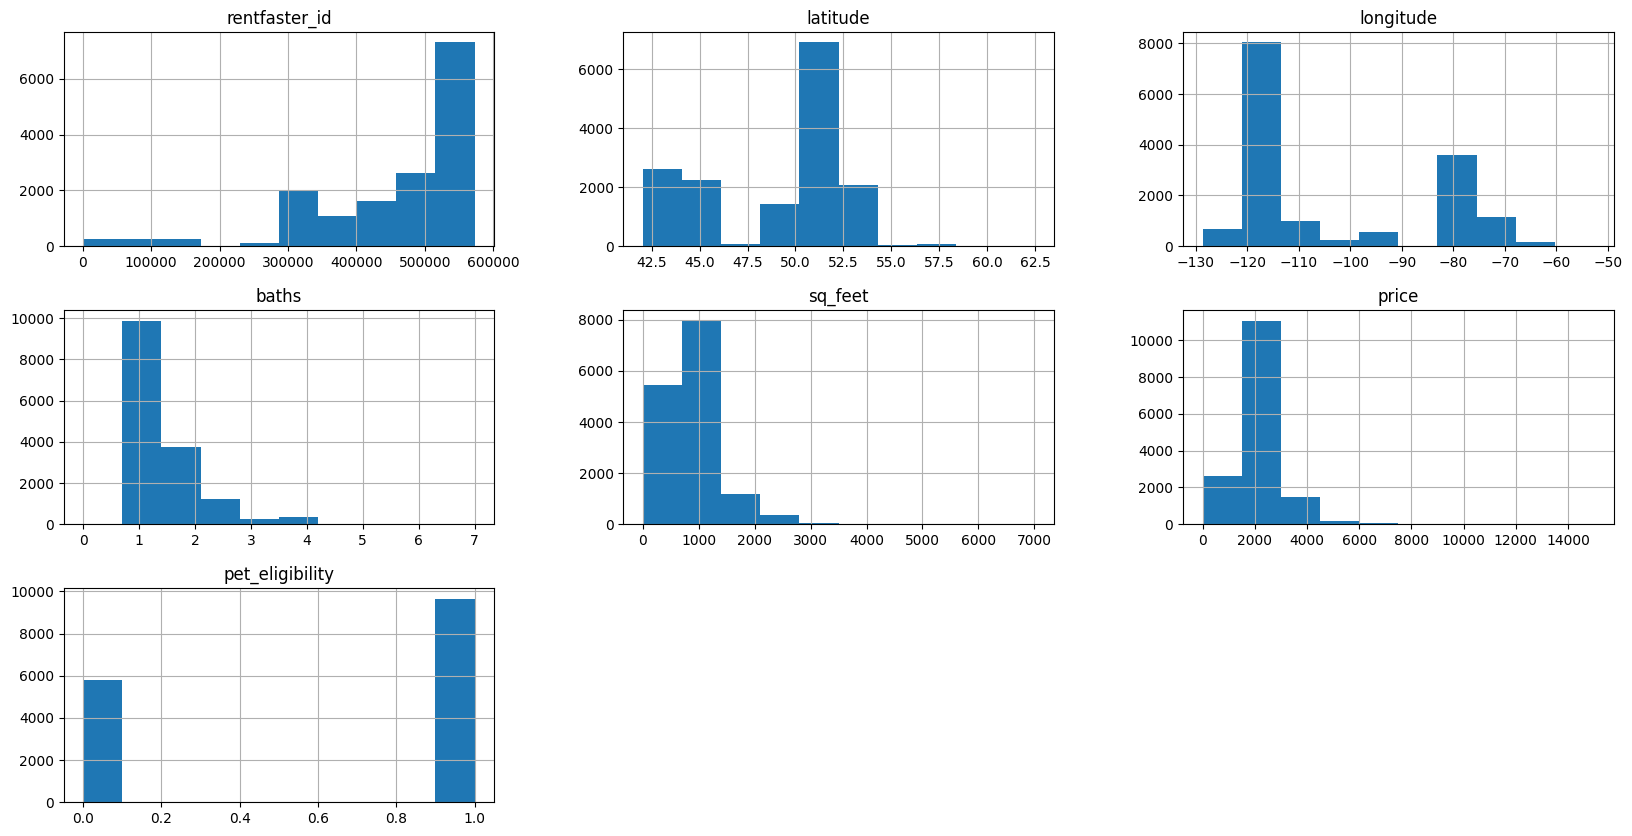

In [19]:
train_data.hist(figsize=(20,10))

In [20]:
train_data['beds'] = train_data['beds'].replace('Studio','0 Beds') # replacing the 'Studio' variable w/ 0 bedrooms by definition, to be able to work with numerically


In [21]:
train_data.beds.value_counts()

beds
2 Beds    6102
1 Bed     5536
3 Beds    2203
0 Beds     929
4 Beds     520
5 Beds     144
6 Beds      30
7 Beds       3
8 Beds       1
9 Beds       1
Name: count, dtype: int64

In [22]:
train_data['beds'] = train_data['beds'].str.split().str[0] # replacing all entries for this column w/ their equivalent numerical value
train_data['beds'] = pd.to_numeric(train_data['beds'].str.split().str[0], errors='coerce')


In [23]:
print(train_data.dtypes)

rentfaster_id          int64
city                  object
province              object
address               object
latitude             float64
longitude            float64
lease_term            object
type                  object
beds                   int64
baths                float64
sq_feet              float64
link                  object
furnishing            object
availability_date     object
smoking               object
cats                  object
dogs                  object
price                float64
pet_eligibility        int32
dtype: object


In [24]:
train_data['total_rooms'] = train_data['beds'] + train_data['baths']
train_data = train_data.drop(['link'],axis=1)
train_data = train_data.drop(['address'],axis=1)
categorical_features = ['city', 'province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking']
for category in categorical_features: 
    train_data = train_data.join(pd.get_dummies(train_data[category], prefix=category, drop_first=True).astype(int))
    train_data.drop(category, axis=1, inplace=True)


train_data['total_rooms'] = np.log(train_data['total_rooms'] + 1) 
train_data['beds'] = np.log(train_data['beds'] + 1) 
train_data['baths'] = np.log(train_data['baths'] + 1) 
train_data['sq_feet'] = np.log(train_data['sq_feet'] + 1)

In [25]:
print(train_data.dtypes)

rentfaster_id                       int64
latitude                          float64
longitude                         float64
beds                              float64
baths                             float64
                                   ...   
availability_date_September 29      int32
availability_date_September 30      int32
smoking_Non-Smoking                 int32
smoking_Smoke Free Building         int32
smoking_Smoking Allowed             int32
Length: 373, dtype: object


In [26]:
test_data = X_test.join(y_test)

In [27]:
test_data['pet_eligibility'] = test_data['cats'] & test_data['dogs']
test_data['pet_eligibility'] = test_data['pet_eligibility'].astype(int) #converts True/False to 1/0
test_data = test_data.drop(['link'], axis=1)
test_data = test_data.drop(['address'],axis=1)

In [28]:
test_data['beds'] = test_data['beds'].replace('Studio','0 Beds') # replacing the 'Studio' variable w/ 0 bedrooms by definition, to be able to work with numerically
test_data['beds'] = test_data['beds'].str.split().str[0] # replacing all entries for this column w/ their equivalent numerical value
test_data['beds'] = pd.to_numeric(test_data['beds'].str.split().str[0], errors='coerce')



test_data['baths'] = pd.to_numeric(test_data['baths'], errors='coerce')
test_data['sq_feet'] = pd.to_numeric(test_data['sq_feet'], errors='coerce')

In [29]:
test_data['total_rooms'] = test_data['beds'] + test_data['baths']

categorical_features = ['city', 'province', 'lease_term', 'type', 'furnishing', 'availability_date', 'smoking']
for category in categorical_features: 
    test_data = test_data.join(pd.get_dummies(test_data[category], prefix=category, drop_first=True).astype(int))
    test_data.drop(category, axis=1, inplace=True)


test_data['total_rooms'] = np.log(test_data['total_rooms'] + 1) 
test_data['beds'] = np.log(test_data['beds'] + 1) 
test_data['baths'] = np.log(test_data['baths'] + 1) 
test_data['sq_feet'] = np.log(test_data['sq_feet'] + 1)




In [30]:
train_data = train_data.apply(pd.to_numeric, errors='coerce')


In [31]:
# Align columns of test data to match the training data
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)


In [32]:
print(test_data.dtypes)

rentfaster_id                       int64
latitude                          float64
longitude                         float64
beds                              float64
baths                             float64
                                   ...   
availability_date_September 29      int64
availability_date_September 30      int32
smoking_Non-Smoking                 int32
smoking_Smoke Free Building         int32
smoking_Smoking Allowed             int32
Length: 373, dtype: object


In [33]:
print(train_data.dtypes)

rentfaster_id                       int64
latitude                          float64
longitude                         float64
beds                              float64
baths                             float64
                                   ...   
availability_date_September 29      int32
availability_date_September 30      int32
smoking_Non-Smoking                 int32
smoking_Smoke Free Building         int32
smoking_Smoking Allowed             int32
Length: 373, dtype: object


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(train_data.drop('price', axis=1), train_data['price'])

In [34]:
# Make predictions on the test data
y_pred = rf_model.predict(test_data.drop('price', axis=1))

# R² Score (Coefficient of Determination)
r2_score = rf_model.score(test_data.drop('price', axis=1), test_data['price'])
print(f'R² Score: {r2_score}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['price'], y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Squared Error (MSE)
mse = mean_squared_error(test_data['price'], y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


R² Score: 0.7940466997705689
Mean Absolute Error (MAE): 149.24197755711214
Mean Squared Error (MSE): 213851.49037556397
Root Mean Squared Error (RMSE): 462.44079661678205


In [1]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_data.drop('price', axis=1), train_data['price'])

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(test_data.drop('price', axis=1))

# Evaluate the predictions
print("R² Score: ", best_rf_model.score(test_data.drop('price', axis=1), test_data['price']))
print("Mean Absolute Error (MAE): ", mean_absolute_error(test_data['price'], y_pred))
print("Mean Squared Error (MSE): ", mean_squared_error(test_data['price'], y_pred))
print("Root Mean Squared Error (RMSE): ", np.sqrt(mean_squared_error(test_data['price'], y_pred)))


NameError: name 'rf_model' is not defined